## 使用气象数据预测AQI

In [44]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

# 读取xlsx文件数据到dataframe
df = pd.read_excel("data_clean.xlsx")
print('原始数据总量：', len(df))
df.head()

原始数据总量： 2192


,plbh,air_pres,temperature,precipitation,wind,700hPa_temp,700hPa_humi,700hPa_wind,AQI,PM2.5,PM10,SO2,NO2,O3,CO
0,0.300000,966.005000,7.374583,0.29,1.647027,-2.989708,78.768875,6.617993,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000
1,0.238750,963.728083,7.228417,0.07,1.167106,1.446208,38.534708,4.679484,197.208333,149.958333,244.291667,10.250000,40.583333,3.333333,-2.448167
2,0.289417,956.998542,7.919708,0.23,1.125223,6.739292,28.552333,8.170507,220.958333,171.666667,298.500000,7.333333,43.458333,15.125000,2.112958
3,0.286917,951.540875,7.493917,0.61,2.082448,4.022125,47.807083,9.069136,57.583333,33.125000,72.875000,-39.208333,-21.291667,-46.208333,-48.750500
4,0.457458,959.087833,8.769583,0.00,1.868800,-7.055250,87.466000,8.726120,131.750000,98.916667,164.958333,3.166667,13.583333,-7.333333,-6.435042


### 一、数据清洗与展示

数据清理后数据量：
 2073


,plbh,air_pres,temperature,precipitation,wind,700hPa_temp,700hPa_humi,700hPa_wind,AQI,PM2.5,PM10,SO2,NO2,O3,CO
0,-0.069362,0.352454,-0.593354,-0.155000,-0.199532,3.763492,-8.491063,-1.419600,66.608333,53.554167,76.487500,6.845833,10.462500,4.645833,5.675371
1,-0.018292,-6.579830,0.082295,0.018182,-0.234990,9.326125,-18.511939,2.110593,91.227273,75.928030,130.314394,4.632576,13.681818,16.912879,10.854080
2,-0.017170,-12.032729,-0.407837,0.386667,0.714435,6.709319,0.312465,3.012183,-82.670139,-71.802083,-109.513889,-45.211806,-54.434028,-45.274306,-40.935958
3,0.158013,-4.505054,0.789609,-0.226154,0.486974,-4.233952,38.354516,2.844289,-11.560897,-8.125000,-19.708333,-3.762821,-20.961538,-5.871795,1.619224
4,0.139568,-0.474964,-0.285393,-0.362857,0.130714,1.479685,-21.510068,1.952266,-69.151786,-61.401786,-92.928571,8.116071,0.074405,-0.276786,1.036164


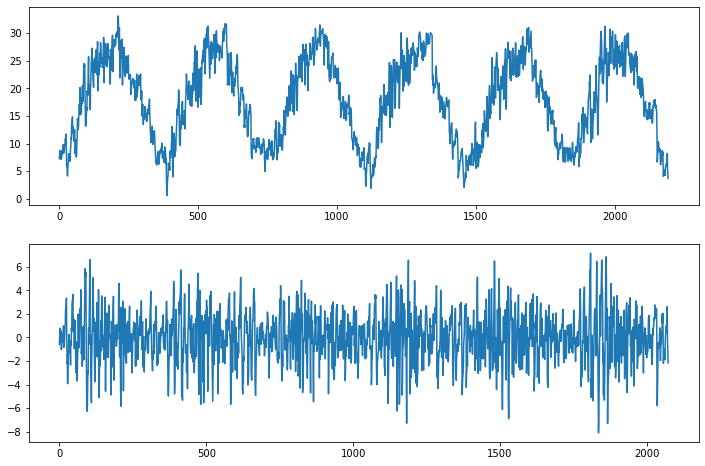

In [45]:
# 清理异常数据
def drop_outliers(dataframe: pd.DataFrame):

    # 对不同的数据列设置阈值范围，筛选合理的数据
    dataframe_drop = dataframe[(dataframe['AQI'] > -0.5) &
                               (dataframe['PM2.5'] > -0.5) &
                               (dataframe['PM10'] > -0.5) &
                               (dataframe['wind'] < 1000) &
                               (dataframe['precipitation'] < 1000) &
                               (dataframe['temperature'] < 1000) &
                               (dataframe['plbh'] > 0)]

    return dataframe_drop

df_drop = drop_outliers(df)
print('数据清理后数据量：\n', len(df_drop))
plt.figure(figsize = (12, 8))
plt.subplot(211)
df_drop['temperature'].plot()


# 定义数据滤波函数：将数据减去附近一段时间（window_size）的均值
# 去均值化处理：保留下来的是数据的高频部分
def data_filter(dataframe: pd.DataFrame, col_index: int, window_size: int):
    # 分别保留原始数据与处理过的数据
    original_array = np.array(dataframe.iloc[:, col_index].values)
    processed_array = np.array(dataframe.iloc[:, col_index].values)

    for i in range(len(original_array)):

        # 存储数据值总和与数据数目
        local_sum, local_count = 0, 0

        for j in range(max(0, i - window_size), min(len(original_array), i + window_size)):
            local_sum += original_array[j]
            local_count += 1

        # 计算平均值，并将原始数据减去均值
        mean_value = local_sum / local_count
        processed_array[i] = original_array[i] - mean_value

    return processed_array

# 对数据进行滤波处理
filter_window_size = 10
col_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
df_filter = pd.DataFrame()
for col_i in col_list:
    df_filter.insert(df_filter.shape[1], list(df.columns)[col_i],
                     data_filter(df_drop, col_i, filter_window_size))

plt.subplot(212)
df_filter['temperature'].plot()
df_filter.head()


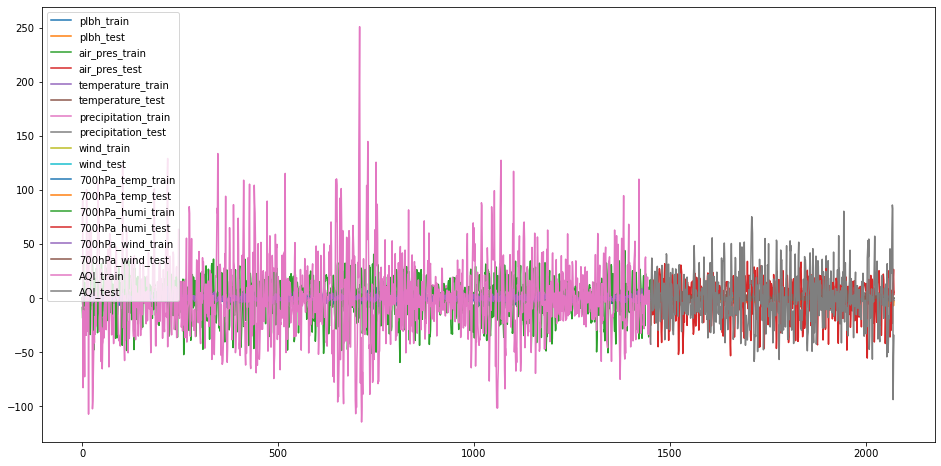

In [46]:
# 筛选所需数据
features = ['plbh', 'air_pres', 'temperature', 'precipitation', 'wind',
            '700hPa_temp', '700hPa_humi', '700hPa_wind', 'AQI']
dataset = df_filter[features]

# 划分训练集、测试集
split = 0.7
train = dataset.loc[:int(len(dataset) * split)]
test = dataset.loc[int(len(dataset) * split):]


# 展示数据
plt.figure(figsize = (16, 8))
for i in range(len(features)):
    plt.plot(train[features[i]], label = features[i] + '_train')
    plt.plot(test[features[i]], label = features[i] + '_test')
plt.legend(loc = 'upper left')
plt.show()

### 二、数据处理与转换

In [47]:
from sklearn.preprocessing import MinMaxScaler

# 将数据归一化、标准化并转化为特征向量
scaler = MinMaxScaler(feature_range=(-1, 1))
train_sc = scaler.fit_transform(train.values)
test_sc = scaler.transform(test.values)

# 选择第k天的气象数据和第k天的空气质量数据预测第k+1天的AQI
X_train = train_sc[:-1, :]
y_train = train_sc[1:, -1]
X_test = test_sc[:-1, :]
y_test = test_sc[1:, -1]

# 对数组进行维度转换
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1451, 9, 1) (1451,) (621, 9, 1) (621,)


### 三、LSTM网络搭建与参数设置

In [48]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.layers import LSTM

# 设计lstm网络模型
lstm_model = Sequential()
lstm_model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]),
                    activation='elu',
                    kernel_initializer='lecun_uniform',
                    return_sequences=True,
                    dropout=0.15,
                    recurrent_dropout=0.2))
lstm_model.add(LSTM(64, activation='elu',
                    return_sequences=False,
                    dropout=0.15))
lstm_model.add(Dense(32))
lstm_model.add(Dense(16))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.summary()

# 设置早停法防止过拟合
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

# 回调函数记录训练过程（损失和准确率等）
history_lstm_model = lstm_model.fit(X_train, y_train,
                                    epochs=30, batch_size=30,
                                    verbose=1, shuffle=True,
                                    callbacks=[early_stop],
                                    validation_split=0.2)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 9, 128)            66560     
                                                                 
 lstm_7 (LSTM)               (None, 64)                49408     
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 118,593
Trainable params: 118,593
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
39/39 [==============================

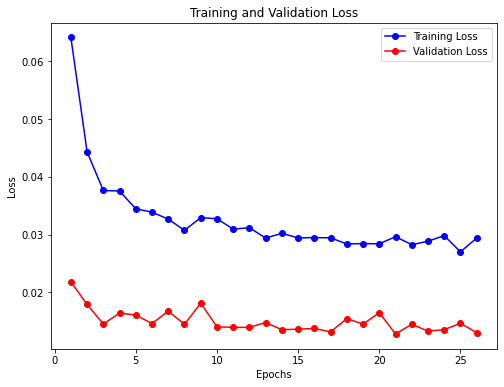

In [49]:
# 打印loss曲线
loss = history_lstm_model.history['loss']
val_loss = history_lstm_model.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize = (8, 6))
plt.plot(epochs, loss, 'bo-', label = 'Training Loss')
plt.plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [51]:
from keras.models import load_model

# 保存或读取 HDF5 文件'my_model.h5'
# lstm_model = load_model('my_model.h5')
lstm_model.save('my_model.h5')

In [52]:
from sklearn.metrics import r2_score, explained_variance_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 使用第 k 日 AQI 数据和 k+1 日气象数据迭代预测 k+1 日 AQI 数据
X_test_new = X_test.copy()
X_test_new[1,-1] = lstm_model.predict(X_test_new[[0]]).flatten()
for i in range(len(X_test_new) - 1):
    X_test_new[:i+1,-1] = lstm_model.predict(X_test_new[:i+1])

y_test_pred_lstm = lstm_model.predict(X_test_new)
y_train_pred_lstm = lstm_model.predict(X_train)

# 输出预测结果的各种评分
print("\nThe R2 score on the Train set is:\t {:0.4f}"
      .format(r2_score(y_train, y_train_pred_lstm)))
print("The R2 score on the Test set is:\t {:0.4f}"
      .format(r2_score(y_test, y_test_pred_lstm)))

print("\nThe explained variance score on the Train set is:\t {:0.4f}"
      .format(explained_variance_score(y_train, y_train_pred_lstm)))
print("The explained variance score on the Test set is:\t {:0.4f}"
      .format(explained_variance_score(y_test, y_test_pred_lstm)))

print("\nThe mean absolute error on the Train set is:\t {:0.4f}"
      .format(mean_absolute_error(y_train, y_train_pred_lstm)))
print("The mean absolute error on the Test set is:\t {:0.4f}"
      .format(mean_absolute_error(y_test, y_test_pred_lstm)))

print("\nThe mean squared error on the Train set is:\t {:0.4f}"
      .format(mean_squared_error(y_train, y_train_pred_lstm)))
print("The mean squared error on the Test set is:\t {:0.4f}"
      .format(mean_squared_error(y_test, y_test_pred_lstm)))



The R2 score on the Train set is:	 0.4565
The R2 score on the Test set is:	 0.3506

The explained variance score on the Train set is:	 0.4565
The explained variance score on the Test set is:	 0.3507

The mean absolute error on the Train set is:	 0.1102
The mean absolute error on the Test set is:	 0.0800

The mean squared error on the Train set is:	 0.0227
The mean squared error on the Test set is:	 0.0113


### 对数据进行逆标准化和逆归一化，并展示最终的预测结果与观测值的比较

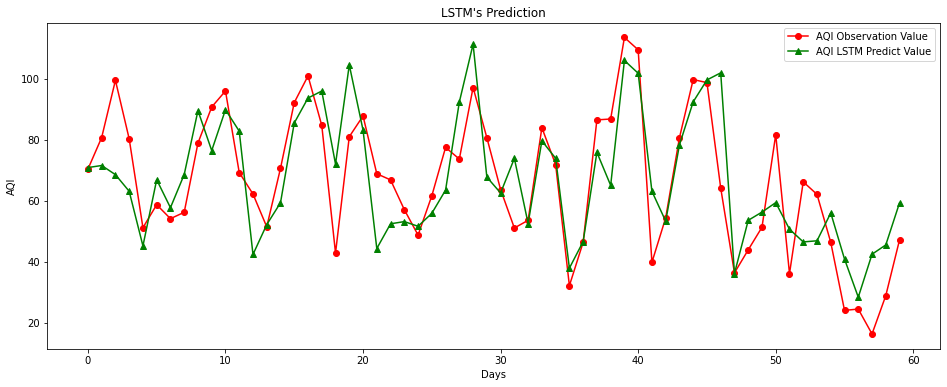

In [53]:
from numpy import concatenate

# 对数据进行逆标准化和逆归一化
X_test_re = X_test_new.reshape((X_test.shape[0], X_test.shape[1]))
inv_yhat = concatenate((X_test_re[:,:-1], y_test_pred_lstm), axis = 1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat

y_test_re = y_test.reshape((len(y_test), 1))
inv_y = concatenate((X_test_re[:,:-1], y_test_re), axis = 1)
inv_y = scaler.inverse_transform(inv_y)


# 将最终得到的数据进行反滤波处理，还原原始数据
start = int(dataset.shape[0]*split)
local_array = np.array(df_drop['AQI'].values)

for i in range(start,len(dataset)-1):
    local_sum, local_count = 0, 0
    
    for j in range((i - filter_window_size), min(len(dataset), i + filter_window_size)):
        local_sum += local_array[j]
        local_count += 1
        
    local_sum /= local_count
    inv_yhat[i-start,-1] += local_sum
    inv_y[i-start,-1] += local_sum

    
# 展示最终的预测结果与观测值的比较
plt.figure(figsize = (16, 6))
plt.plot(inv_y[:60,-1], 'ro-', label = 'AQI Observation Value')
plt.plot(inv_yhat[:60,-1], 'g^-', label = 'AQI LSTM Predict Value')
plt.title("LSTM's Prediction")
plt.xlabel('Days')
plt.ylabel('AQI')
plt.legend()
plt.show()

### 设计评价指标：平均相对误差(Mean Relative Error)与均方相对误差(Mean Squared Relative Error)

目的为计算LSTM网络预测的准确程度，使用观测值和预测值的相对误差进行统计。\
计算方式为：

$$ MRE = \frac{1}{n}\sum_{i=1}^n\left|{\frac{y-y_0}{y_0}}\right| $$
$$ MSRE = \sqrt{\frac{1}{n}\sum_{i=1}^n\left({\frac{y-y_0}{y_0}}\right)^2} $$

其中$y$为LSTM网络AQI预测值，$y_0$为AQI实际观测值，$n$为样本数目。\
预测准确率$acc$基于MRE进行计算：
$$ acc = (1-MRE)\times100\% 
= \left(1-\frac{1}{n}\sum_{i=1}^n\left|{\frac{y-y_0}{y_0}}\right|\right)\times100\% $$

In [54]:
# 计算平均相对误差（MRE）与均方相对误差（MSRE）
time = 30
mre, msre = 0, 0

for i in range(time):
    mre += abs((inv_yhat[i,-1] - inv_y[i,-1])/inv_y[i,-1])
    msre += ((inv_yhat[i,-1] - inv_y[i,-1])/inv_y[i,-1]) ** 2

msre = (msre / (time + 1)) ** 0.5
mre = mre / (time + 1)

print("The Mean Squared Relative Error of the prediction is:\t {:0.4f}".format(mre))
print("\nThe Mean Relative Error of the prediction is:\t {:0.4f}".format(msre))
print("\nThe overall accuracy of the prediction is:\t {:0.3f}%".format((1-mre) * 100))

The Mean Squared Relative Error of the prediction is:	 0.1633

The Mean Relative Error of the prediction is:	 0.2097

The overall accuracy of the prediction is:	 83.666%


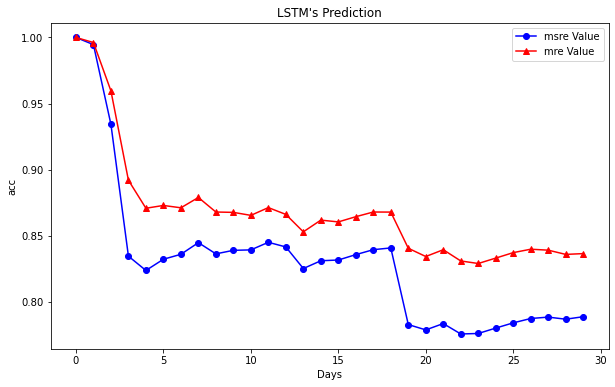

In [55]:
# 打印 MRE 与 MSRE 的变化趋势
time = 30
mre_arr, msre_arr = [], []
for t in range(time):
    mre, msre = 0, 0
    for i in range(t):
        mre += abs((inv_yhat[i,-1] - inv_y[i,-1])/inv_y[i,-1])
        msre += ((inv_yhat[i,-1] - inv_y[i,-1])/inv_y[i,-1]) ** 2
    mre_arr.append(1 - mre / (t + 1))
    msre_arr.append(1 -(msre / (t + 1)) ** 0.5)

plt.figure(figsize = (10, 6))
plt.plot(msre_arr[:], 'bo-', label = 'msre Value')
plt.plot(mre_arr[:], 'r^-', label = 'mre Value')
plt.title("LSTM's Prediction")
plt.xlabel('Days')
plt.ylabel('acc')
plt.legend()
plt.show()

In [56]:
print(inv_y[:30,-1])
print(inv_yhat[:30,-1])

[ 70.31875     80.68541667  99.41666667  80.27083333  51.1625
  58.69375     54.12083333  56.20625     78.87291667  90.67708333
  95.94375     69.23333333  62.1875      51.44583333  70.60416667
  92.12916667 100.86041667  84.65625     42.86875     80.95833333
  87.75625     68.83125     66.8125      57.08333333  48.74166667
  61.60625     77.45625     73.64166667  97.06875     80.63541667]
[ 70.85564548  71.52772979  68.53785072  63.09201714  45.20299334
  66.87570671  57.71556305  68.56934636  89.49539098  76.42442333
  89.80092964  82.78029668  42.40132396  52.17577495  59.324372
  85.44669426  93.61939878  95.91594685  71.98941448 104.46219618
  83.12146514  44.34214771  52.43705419  53.15935541  51.6259911
  55.87529064  63.47676451  92.31977409 111.25334559  67.72969955]
